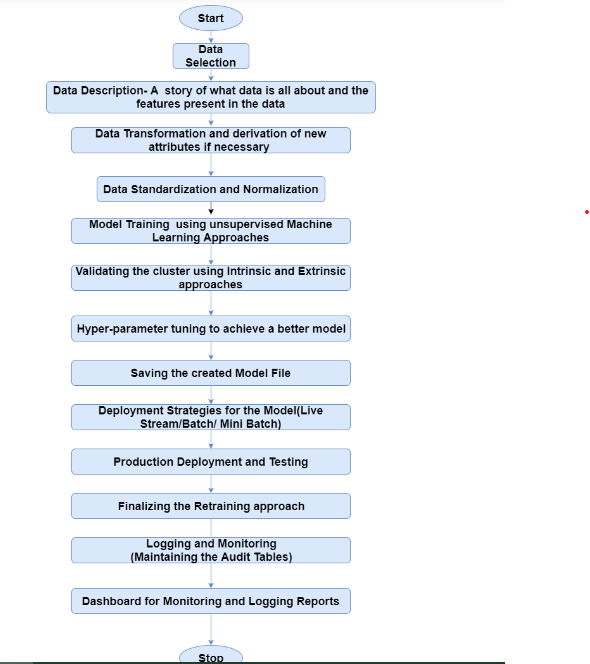

https://www.mathworks.com/help/stats/hierarchical-clustering.html

https://www.originlab.com/doc/Origin-Help/Cluster-Analysis

https://scikit-learn.org/stable/modules/clustering.html

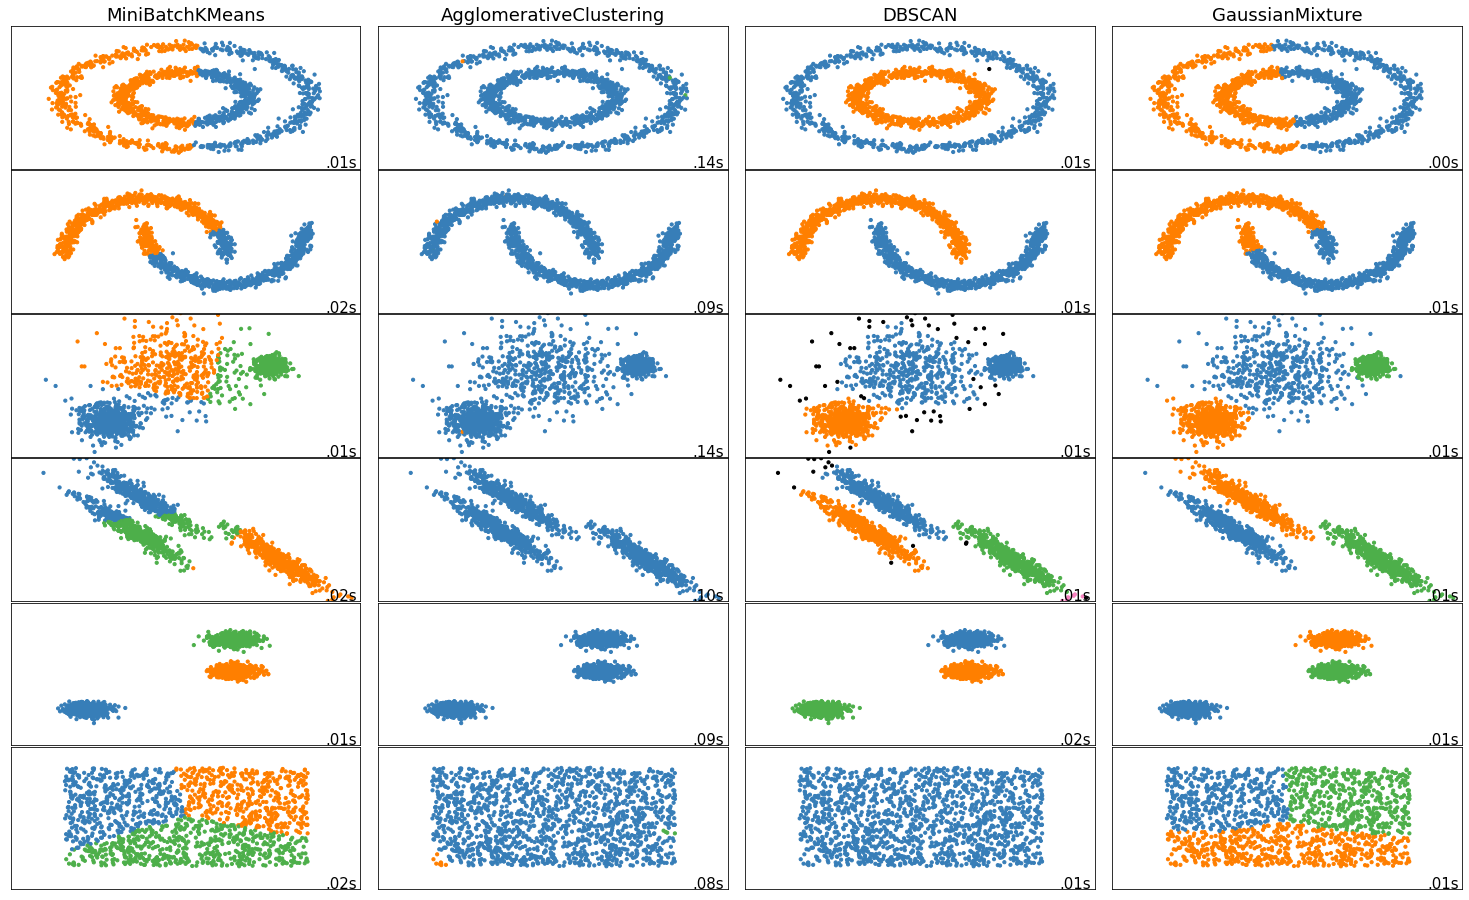

In [15]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .25,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
   
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
    
    dbscan = cluster.DBSCAN(eps=params['eps'])
    
    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
    
    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### 1. What is an unsupervised learning approach? Why is it needed?

Unsupervised learning is a type of machine learning that looks for previously undetected patterns in a data set with no pre-existing labels and with a minimum of human supervision. 

**Need:** As first step during Data Analysis, need to understand inherent structure from the input data which is unlabelled.The goal of clustering is to determine the intrinsic groups in unlabeled data.

This approach is required so that it allows the model to work on its own to discover patterns and information that was previously undetected.It mainly deals with the unlabelled data.

### 2. What is clustering?

A cluster is a collection of objects which are “similar” amongst themselves and are “dissimilar” to the objects belonging to a different cluster.

Clustering is an unsupervised approach which finds a structure/pattern in a collection of unlabeled data. The goal of clustering is to determine the intrinsic groups in unlabeled data. 

### 3.	How do clustering and classification differ?

Classification is supervised learning, while Clustering is un-supervised learning.

Classification is the process of classifying the data with the help of class labels whereas, in clustering, there are no predefined class labels.

Classification has prior knowledge of classes on the examples being trained but the cluster doesn't have any prior knowledge of classes.

### 4.	What are the various applications of clustering?

**For Customer Segmentation:** Cluster your customers based on their purchases,their activity on your website, and so on. This is useful to understand who your customers are and what they need, so you can adapt your products and marketing campaigns to each segment. 

For example, this can be useful in recommender systems to suggest content that other users in the same cluster enjoyed.

**For Data Analysis:** When analyzing a new dataset, it is often useful to first discover clusters of similar instances, as it is often easier to analyze clusters separately.

**As a Dimensionality Reduction technique:** Once a dataset has been clustered, it is usually possible to measure each instance’s affinity with each cluster (affinity is any measure of how well an instance fits into a cluster). Each instance’s feature vector x can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k dimensional. This is typically much lower dimensional than the original feature vector, but it can preserve enough information for further processing.

**For Anomaly/Outlier detection:** Any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clustered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual number of requests per second, and so on. Anomaly detection is particularly useful in detecting defects in manufacturing, or for fraud detection.

**For semi-supervised learning:** If you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster. This can greatly increase the amount of labels available for a subsequent supervised learning algorithm, and thus improve its performance. .

**For search engines:** For example, some search engines let you search for images that are similar to a reference image. To build such a system, you would first apply a clustering algorithm to all the images in your database: similar images would end up in the same cluster. Then when a user provides a reference image, all you need to do is to find this image’s cluster using the trained clustering model, and you can then simply return all the images from this cluster.

**To segment an image:** By clustering pixels according to their color, then replacing each pixel’s color with the mean color of its cluster, it is possible to reduce the number of different colors in the image considerably. This technique is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object.

### 5.	How does clustering play a role in supervised learning?

Clustering is an unsupervised machine learning approach, but can it be used to improve the accuracy of supervised machine learning algorithms as well by clustering the data points into similar groups and using these cluster labels as independent variables in the supervised machine learning algorithm.

Clustering mainly deals with finding a structure or pattern in a collection of uncategorized data.Clustering algorithms will process your data and find natural clusters(groups) if they exist in the data.

### 6.	What are the requirements to be met by a clustering algorithm?

- scalable
- ability to deal with attributes of different types
- ability to discover arbitrary shape clusters
- inbuilt ability to deal with noise and outliers
- not vary with the order of input records
- ability to handle data of high dimensions
- easy to interpret and use

### 7.	Discuss the different approaches for clustering.

**Agglomerative:** This approach first considers all the points as individual clusters and then finds out the similarity between two points, puts them into a cluster. Then it goes on finding similar points and clusters until there is only one cluster left i.e., all points belong to a big cluster. This is also called the **bottom-up approach. (Individual data points to Large cluster)**

**Divisive:** It is opposite of the agglomerative approach. It first considers all the points to be part of one big cluster and in the subsequent steps tries to find out the points/ clusters which are least similar to each other and then breaks the bigger cluster into smaller ones. This continues until there are as many clusters as there are datapoints. This is also called the **top-down approach. (Larger cluster to Individual data points)**

### 8.	What is WCSS?

 **W**ithin **C**luster **S**um of **S**quared distances

WCSS is the sum of squares of the distances of each data point in all clusters to their respective centroids.
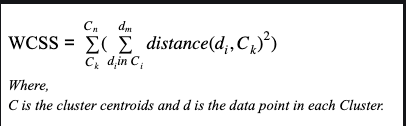

### 9.	What is the significance of ‘K’ in K-Means and how is it calculated?

K-Means is a clustering approach in which the data is grouped into K distinct non-overlapping clusters based on their distances from the K centres. The value of K needs to be specified first and then the algorithm assigns the points to exactly one cluster.

There ia need to provide the value of K beforehand. An optimum value of K is obtained using the Elbow Method.

### 10.	Discuss the elbow method.

#### The Elbow-Method (Only for K-Means)
- This method is based on the relationship between the **WCSS** and the **Number of Clusters**. 
- It is observed that first with an increase in the number of clusters WCSS decreases steeply and then after a certain number of clusters the drop in WCSS is not that prominent. 
- The point after which the graph between WCSS and the number of clusters becomes comparatively smother is termed as the elbow and the number of cluster at that point are the optimum number of clusters as even after increasing the clusters after that point the variation is not decreasing by much.

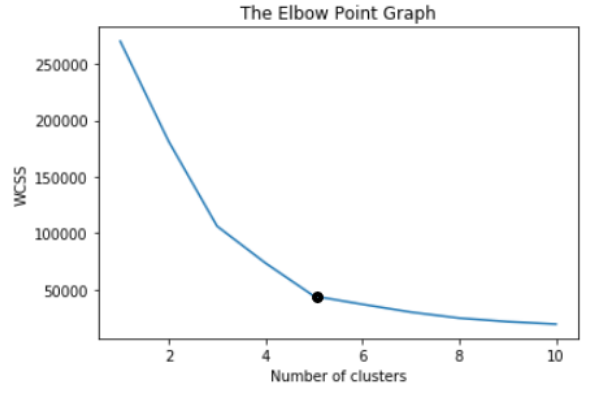


### 11.	Discuss the step by step implementation of K-Means Clustering.

K-means clustering is a clustering method that subdivides a single cluster or a collection of data points into K different clusters or groups. 

1. Randomly assign K centres/centroids.
2. Calculate the distance of all the points from all the K centres and allocate the points to cluster based on the shortest distance. The model’s **inertia (WCSS)** is the mean squared distance between each instance and its closest centroid. The goal is to have a model with the lowest intertia.
3. Once all the points are assigned to clusters, recompute the centroids.
4. Repeat the steps 2 and 3 until the locations of the centroids stop changing and the cluster allocation of the points becomes constant.

### 12.	What are the challenges with K-Means?

#### Challenges in K-Means:

1.	Need to specify the number of clusters beforehand.
2.	The clusters sometimes vary based on the initial choice of the centroids. 
3.	It is required to run the algorithm multiple times to avoid a sub-optimal solution
4.	K-Means does not behave very well when the clusters have outliers, varying sizes, different densities, or non-spherical shapes.



### 13.	Discuss the various improvements in K-Means.

#### Improvements in K-Means:
- An important improvement to the K-Means algorithm, called **K-Means++**, which does **smarter initialization** step that tends to select centroids that are distant from one another, and this makes the K-Means algorithm much less likely to converge to a suboptimal solution.
- Another important improvement in 2003 to the K-Means algorithm was proposed, which considerably accelerates the algorithm by avoiding many unnecessary distance calculations: this is achieved by exploiting the **triangle inequality**
 - (i.e., the straight line is always the shortest; in a triangle with sides a,b and c:  **a+b>c**) and by keeping track of lower and upper bounds for distances between instances and centroids. 
- 2010 Improvement: Instead of using the full dataset at each iteration, the algorithm is capable of using **Mini-Batches**, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of 3 or 4 and makes it possible to cluster huge datasets that do not fit in memory. 
 - Scikit-Learn implements this algorithm in the **MiniBatchKMeans** class.

### 14.	Discuss the agglomerative and divisive clustering approaches.

The clustering approaches can be broadly divided into two categories: Agglomerative and Divisive.

**Agglomerative:** This approach first considers all the points as individual clusters and then finds out the similarity between two points, puts them into a cluster. Then it goes on finding similar points and clusters until there is only one cluster left i.e., all points belong to a big cluster. This is also called the bottom-up approach.

**Divisive:** It is opposite of the agglomerative approach. It first considers all the points to be part of one big cluster and in the subsequent steps tries to find out the points/ clusters which are least similar to each other and then breaks the bigger cluster into smaller ones. This continues until there are as many clusters as there are datapoints. This is also called the top-down approach.

### 15.	What are dendrograms?

A dendrogram is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering. The main use of a dendrogram is to work out the best way to allocate objects to clusters. The dendrogram below shows the hierarchical clustering of six observations shown on the scatterplot to the left. 

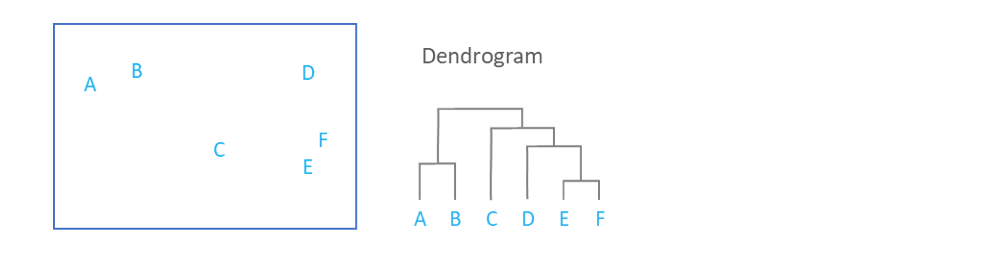

### 16.	Discuss the Hierarchical clustering in detail.

#### Hierarchical clustering
One main disadvantage of K-Means is that it needs us to pre-enter the number of clusters (K). Hierarchical clustering is an alternative approach which does not need us to give the value of K beforehand and also, it creates a beautiful tree-based structure for visualization.

Here, we are going to discuss the bottom-up (or Agglomerative) approach of cluster building. We start by defining any sort of similarity between the datapoints. Generally, we consider the Euclidean distance. The points which are closer to each are more similar than the points which are farther away. The Algorithms starts with considering all points as separate clusters and then grouping points together to form clusters.

#### The Algorithm:

1. Begin with n observations and a measure (such as Euclidean distance) of all the n(n−1)/2 pairwise dissimilarities(or the -Euclidean distances generally). Treat each observation as its own cluster. Initially, we have n clusters.
2. Compare all the distances and put the two closest points/clusters in the same cluster. The dissimilarity(or the Euclidean distances) between these two clusters indicates the height in the dendrogram at which the fusion line should be placed.
3. Compute the new pairwise inter-cluster dissimilarities(or the Euclidean distances) among the remaining clusters.
4. Repeat steps 2 and 3 till we have only one cluster left.

### 17.	Discuss the various linkage methods for clustering.

Use a linkage criterion to merge data points (at the first stage) or clusters (in subsequent phases). Where the linkage is represented by a function such as:

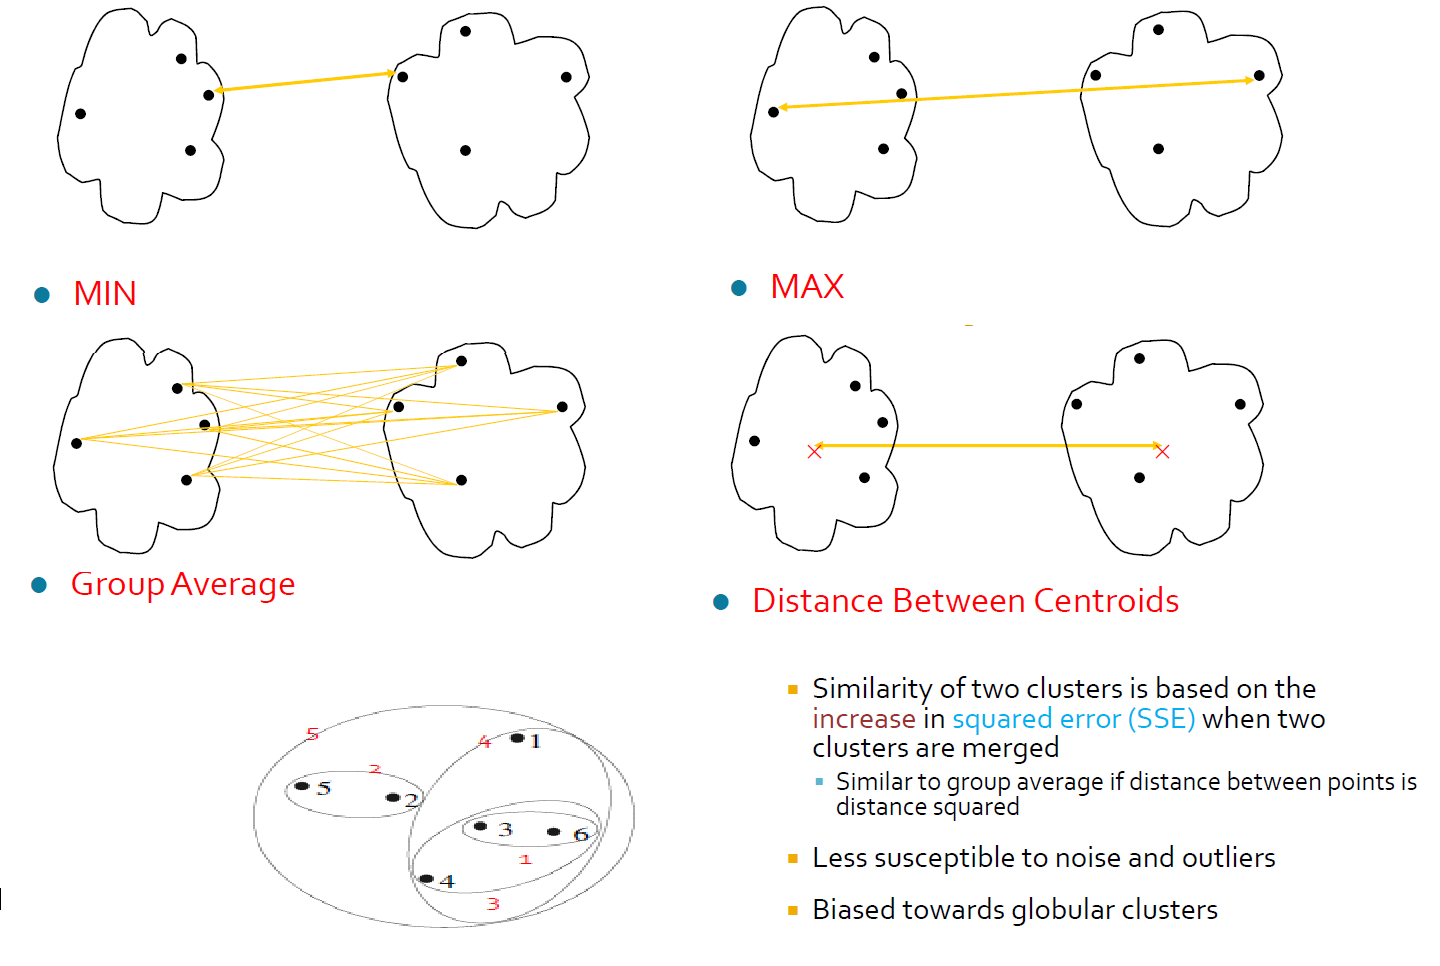
#### Minimum or single linkage clustering :  
It computes all pairwise dissimilarities between the elements in cluster 1 and the elements in cluster 2. And considers the smallest of these dissimilarities as a linkage criterion. It tends to produce long, “loose” clusters.

#### Maximum or complete linkage clustering :  
It computes all pairwise dissimilarities between the elements in cluster 1 and the elements in cluster 2. And considers the largest value (i.e., maximum value) of these dissimilarities as the distance between the two clusters. It tends to produce more compact clusters.

#### Mean or average linkage clustering :  
It computes all pairwise dissimilarities between the elements in cluster 1 and the elements in cluster 2. And considers the average of these dissimilarities as the distance between the two clusters.
#### Centroid linkage clustering : 
It computes the dissimilarity between the centroid for cluster 1 (a mean vector of length p variables) and the centroid for cluster 2.           
#### Ward’s minimum variance method  :
It minimizes the total within-cluster variance. The pair of clusters with minimum between-cluster distance are merged at each step.

- **Single Linkage:**   cluster distance = smallest pairwise distance
- **Complete Linkage:** cluster distance = largest pairwise distance
- **Average Linkage:**  cluster distance = average pairwise distance
- **Centroid Linkage:** cluster distance = distance between the centroids of the clusters
- **Ward’s Linkage:**   cluster criteria = Minimize the variance in the cluster

### 18.	Discuss the differences between K-Means and Hierarchical clustering.

#### Difference between K Means and Hierarchical clustering
- H-clustering can’t handle big data well but K Means clustering can. This is because the time complexity of K Means is linear i.e. O(n). While that of hierarchical clustering is quadratic i.e. O(n2).
- In K Means clustering, since we start with random choice of clusters. The results produced by running the algorithm multiple times might differ. While results are reproducible in H-clustering.
- K Means is found to work well when the shape of the clusters is hyper spherical (like circle in 2D, sphere in 3D).
- K Means clustering requires prior knowledge of K i.e. no. of clusters you want to divide your data into. But, you can stop at whatever number of clusters you find appropriate.  In hierarchical clustering it can be done by interpreting the dendrogram.

### DBSCAN
### 19.	Discuss the basic terms used in DBSCAN.

#### DBSCAN(Density Based Spatial Clustering of Applications with Noise)

It is an unsupervised machine learning algorithm.This algorithm defines clusters as continuous regions of high density.

Some definitions first:

**Epsilon:** This is also called eps. This is the distance till which we look for the neighbouring points.

**Min_points:** The minimum number of points specified by the user.

**Core Points:** If the number of points inside the _eps radius_ of a point is greater than or equal to the *min_points* then it’s called a core point.

**Border Points:** If the number of points inside the _eps radius_ of a point is less than the *min_points* and it lies within the _eps radius_ region of a core point, it’s called a border point.

**Noise:** A point which is neither a core nor a border point is a noise point.

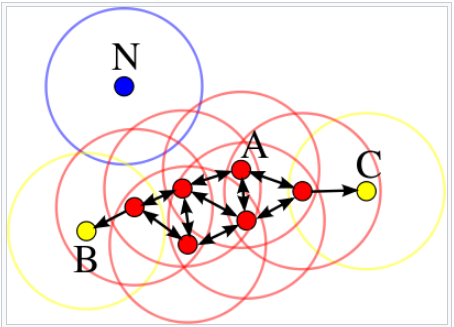

In this diagram, minPts = 4. Point A and the other red points are core points, because the area surrounding these points in an ε radius contain at least 4 points (including the point itself). Because they are all reachable from one another, they form a single cluster. Points B and C are not core points, but are reachable from A (via other core points) and thus belong to the cluster as well. Point N is a noise point that is neither a core point nor directly-reachable.

### 20.	Discuss the step by step implementation of DBSCAN.


Algorithm Steps:

1.	The algorithm starts with a random point in the dataset which has not been visited yet and its neighbouring points are identified based on the eps value.
2.	If the point contains greater than or equal points than the min_pts, then the cluster formation starts and this point becomes a _core point_, else it’s considered as noise. The thing to note here is that a point initially classified as noise can later become a border point if it’s in the eps radius of a core point.
3.	If the point is a core point, then all its neighbours become a part of the cluster. If the points in the neighbourhood turn out to be core points then their neighbours are also part of the cluster.
4.	Repeat the steps above until all points are  classified into different clusters or noises.



This algorithm works well if all the clusters are dense enough, and they are well separated by low-density regions.

### Cluster Evaluation
### 21.	What are the aspects of cluster validation?

#### A good cluster will have:_
* High inter-class similarity, and 
* Low intraclass similarity



#### Aspects of cluster validation

* **External:** Compare your cluster to the ground truth.
* **Internal:** Evaluating the cluster without reference to external data.
* **Reliability:** The clusters are not formed by chance(randomly)- some statistical framework can be used.

### 22.	What is a confusion matrix?

**Confusion matrix:**

$n$ = number of points

$m_i$ = points in _cluster i_

$c_j$ = points in _class j_

$n_{ij}$ =  points in cluster i coming from cluster j

$p_{ij}=\frac{n_{ij}}{m_i}$= probability of element from cluster i to be assigned to class j

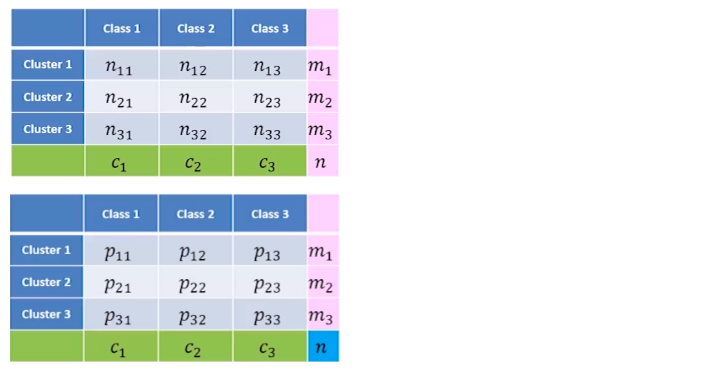

### 23.	What is Jaccard’s coefficient?

N: Number of objects in the data
P: ${P_1,P_2,…,P_m}$ the set of ground truth clusters
C: ${C_1,C_2,…C_n}$ the set of clusters formed by the algorithm

The Incidence Matrix:
N* N matrix

$P_{ij} =1$ if the two points $O_i$ and $O_j$ belong to the same cluster in the ground truth else $P_{ij}=0$ 

$C_{ij} =1$ if the two points $O_i$ and $O_j$ belong to the same cluster in the cluster else $C_{ij}=0$ 

Now there can be the following scenarios:
1.	$C_{ij}=P_{ij}=1$ --> both the points belong to the same cluster for both our algorithm and ground truth(Agree)--- **SS**
2.	$C_{ij}=P_{ij}=0$ --> both the points don’t belong to the same cluster for both our algorithm and ground truth(Agree)--- **DD**
3.	$C_{ij}=1 but P_{ij}=0$ --> The points belong in the same cluster for our algorithm but in different clusters for the ground truth (Disagree)---- **SD**
4.	$C_{ij}=0 but P_{ij}=1$ --> The points don’t belong in the same cluster for our algorithm but in same clusters for the ground truth (Disagree)----**DS**


**Jaccard Coeficient**=$\frac{ SS}{(SS+SD+DS)}$

### 24.	What is Rand Index?


**Rand Index**= $\frac{Total Agree}{Total Instances}=\frac{(SS+DD)}{(SS+DD+DS+SD)}$

The disadvantage of this is that it could be dominated by DD.





### 25.	What is the entropy of a cluster?

**Entropy** 

Entropy of Cluster i, given by $e_i= - \sum p_{ij} log (p_{ij})$

For the entire clustering algorithm, the entropy can be given as: 
$e= \sum \frac{m_i}{n}e_i$

### 26.	Discuss the purity of a cluster.

**Purity**

The purity is the total percentage of data points clustered correctly. A high value of purity score means that our clustering algorithm performs well against the ground truth.

 The purity of  cluster i, given by $p_i=max (p_{ij})$ 

And for the entire cluster it is: $p(C)=\sum \frac{p_i}{n}$


### 27.	What are cohesion and compression?

#### Internal Measures

These are the methods use to measure the quality of clusters without external references. There are two aspects to it.

* **Cohesion:** How closely the objects in the same cluster are related to each other. It is the within-cluster sum of squared distances. It is the same metric that we used to calculate for the K-Means algorithm.
$WCSS= \sum \sum (x-m_i)^2$

* **Separation:** How different the objects in different clusters are and how distinct a well-separated cluster is from other clusters. It is the between cluster sum of squared distances. $BSS=\sum C_i(m-m_i)^2$

Where C is the size of the individual cluster and m is the centroid of all the data points.

**Note:** BSS+WSS is always a constant.

The silhouette  can be calculated as:
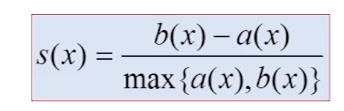

Where a(x) is the avarage distance of x from all the other points in the same cluster and b(x) is the avarage distance of x from all the other points in the other clusters.


And the Silhoeutte coefficient is given by:

$SC=\frac{1}{N} \sum S(x)$

### 28.	What are the steps for Azure deployment?

1. Create the desired project structure format.
   - app.py
   - required model's pickle file
   - requirements.txt
   - and all required components to run. (if using flask framework then required format)
2. Go to the Azure account and create a web app in the portal:https://portal.azure.com/
3. Provide the app name, resource group(create new if necessary), runtime stack(Python 3.7), region, select the 1 GB size, which is free to use. Click Review+create to create the web app.
4. Once the deployment is completed, open the app and go to the ‘Deployment Center’ option. Select ‘local git’ for source control and click continue.
5. Select the kudo ‘App service build provider’ as the build provider and click continue.
6. Click ‘Finish’ to complete the setup.
7. Go to ‘Deployment Credentials’ in deployment center and copy the username and password. These will be required when doing the final push to the remote git repository.
8. Open a command prompt and navigate to your project folder.
9. Run git init to initialise an empty git repository
10. Create a new remote git alias using the command: git remote add
11. Use git add . to add all the files to the local git repository.
12. Use git commit -m "first commit" to commit the code to the git repo.
13. Push the code to the remote repo using: git push master –f
14. This prompts for a username and password. Provide the same credentials as copied in the step above.
15. After deployment, from the ‘overview’ section, copy the URL and paste into any web API test to see the application running.   

### 29.	What difficulties did you face while deploying to Azure?

Using Git Commands slighly faced inconvinence..

http://clustering-mall.azurewebsites.net

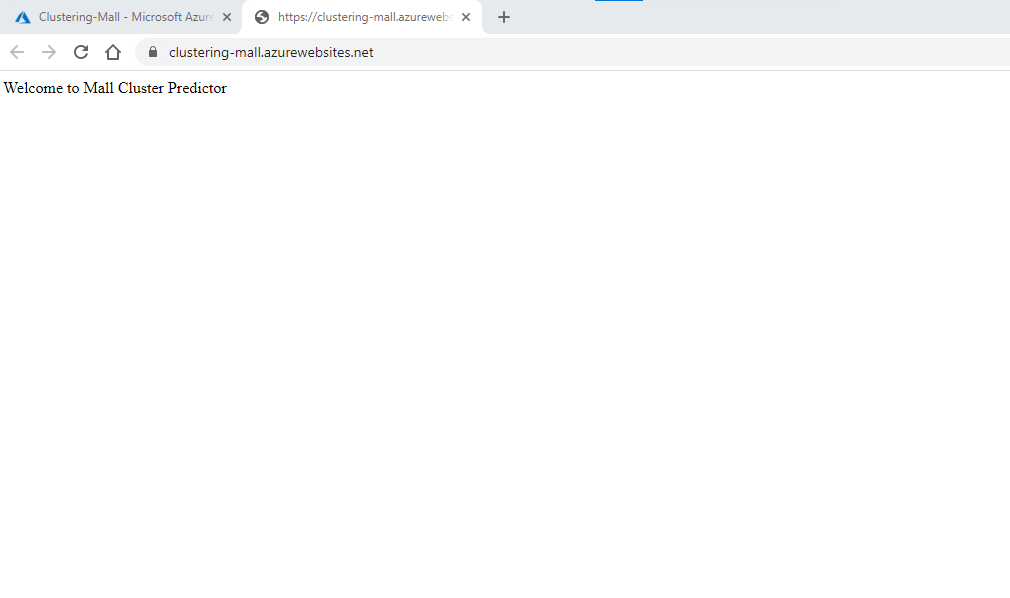

http://clustering-mall.azurewebsites.net/apidocs/

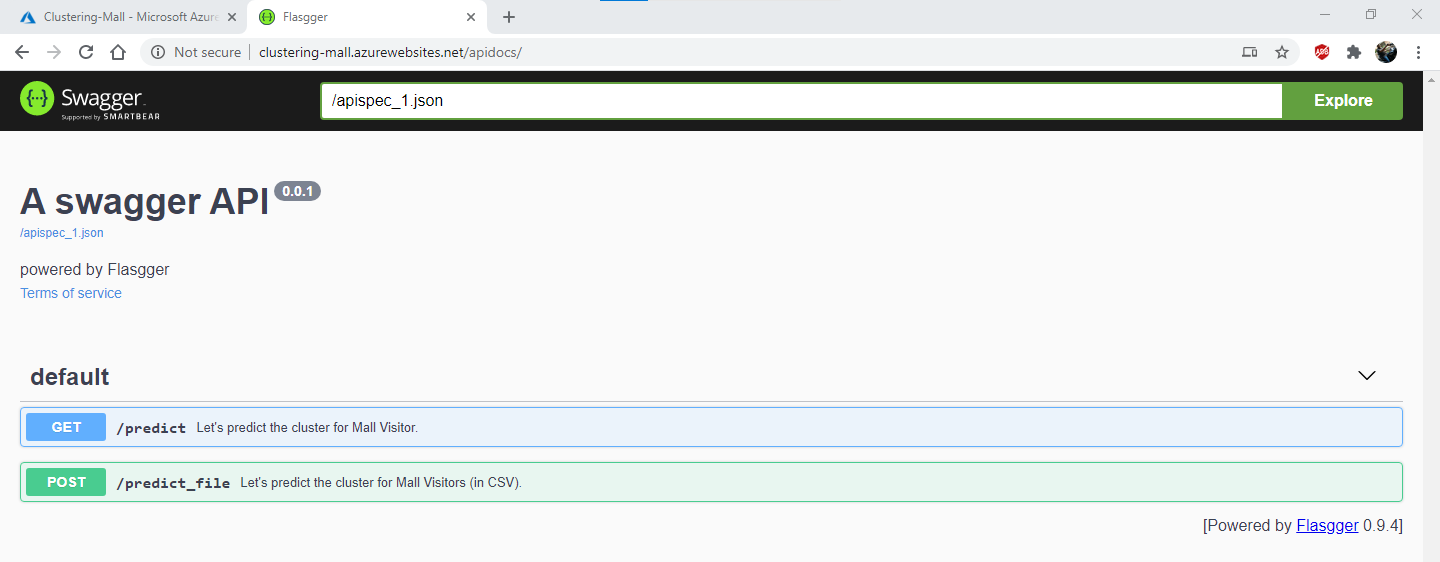

Single Entity Prediction

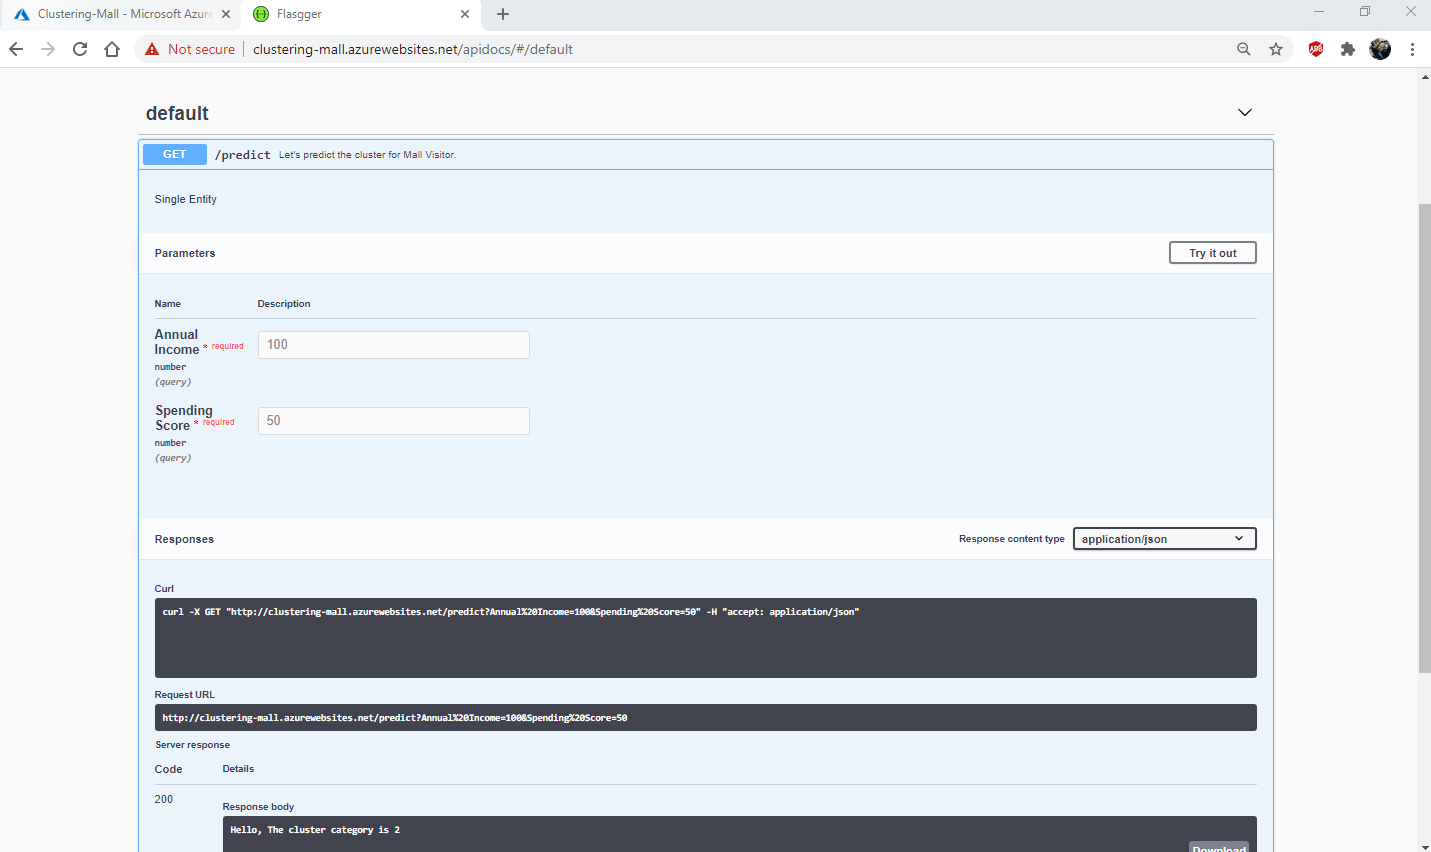

Bulk Prediction

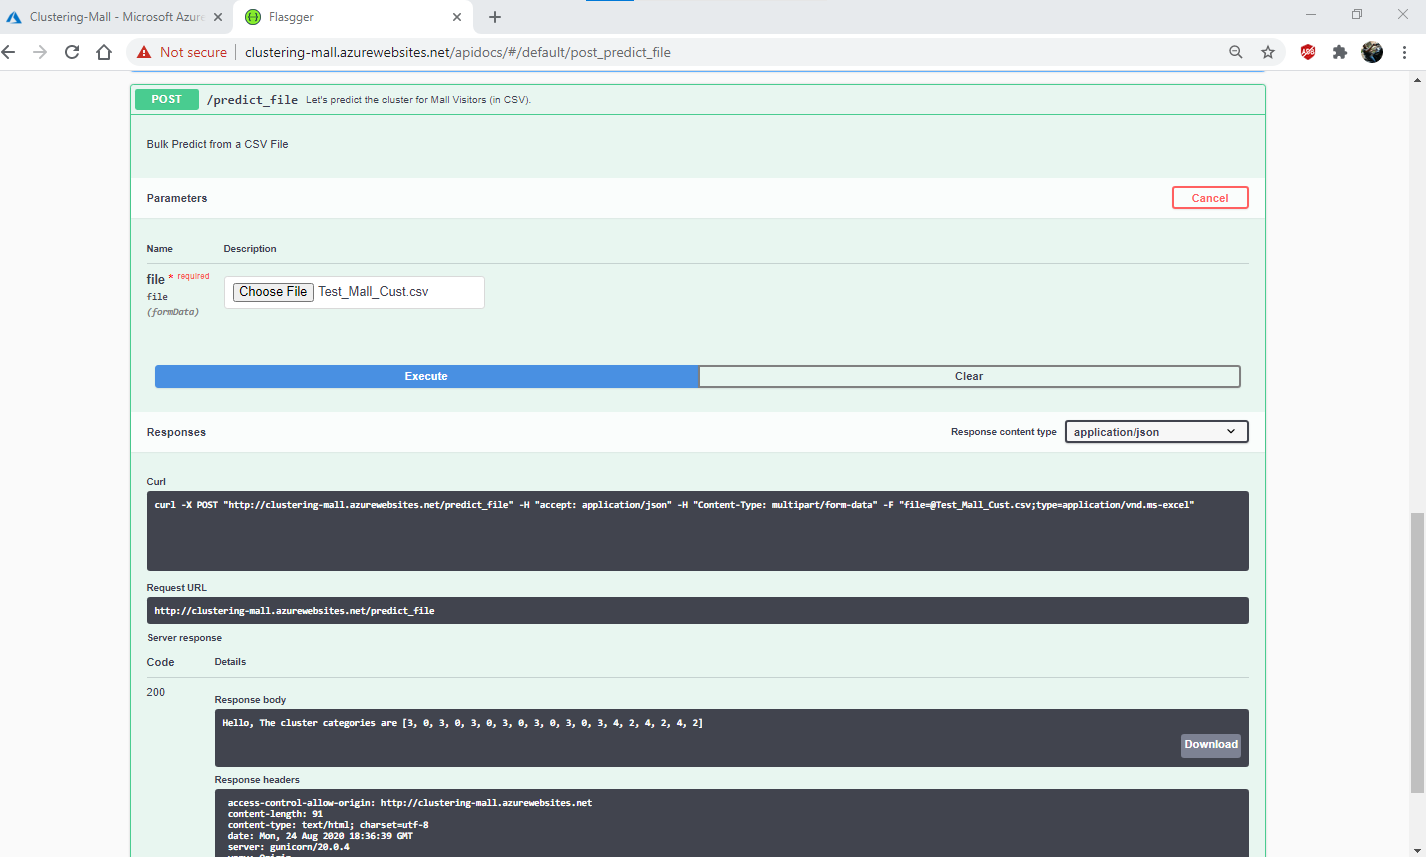

Facebook Research 
Github Trend


Sevices - Azure

Resources / Capability - AWS

https://ai.googleblog.com/2020/03/real-time-3d-object-detection-on-mobile.html
